## Inhibitory and excitatory mechanisms of selectivity:
Let's consider a neuron that has a receptive field - it is selectively activated for some stimuli in-field and not other stimuli out-of-field.
What are some possible mechanisms to generate this selectivity?
1. Increased firing rate of excitatory presynaptic inputs in-field.
2. Increased synaptic weights of excitatory inputs active in-field.
3. Decreased firing rate of inhibitory presynaptic inputs in-field.
4. Decreased synaptic weights of inhibitory inputs active in-field.

In this tutorial, we'll explore some concepts and measurements in order to model each of these mechanisms and compare their predictions.
- Poisson spike generation
- Neuronal input resistance, capacitance, and membrane potential
- Current-based synapses
- Conductance-based synapses
- Analysis of membrane potential fluctuations
- Voltage-dependent ion channels - NMDA-type glutamate receptors

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(2)

On generating spike trains consistent with a target firing rate:

A homogeneous Poisson process takes an event probability, and samples from a binomial distribution to generate a random sequence with the number of events in a time bin.<br>
The resulting sequence has equal mean and variance.<br>
We can use this method to obtain a spike train with a constant mean rate, in time bins with our desired resolution.

<IPython.core.display.Javascript object>


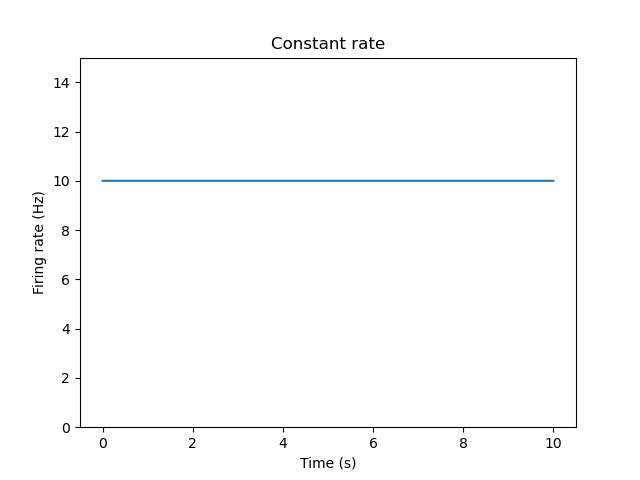

Text(0.5, 1.0, 'Constant rate')

In [2]:
# 10 seconds at 1 millisecond resolution
dur = 10.  # seconds
dt = 0.001  # seconds
t = np.arange(0, dur, dt)  

mean_rate = 10.  # Hz

example_rate = np.ones_like(t) * mean_rate

plt.figure()
plt.plot(t, example_rate)
plt.ylim(0., 15.)
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (s)')
plt.title('Constant rate')

<IPython.core.display.Javascript object>


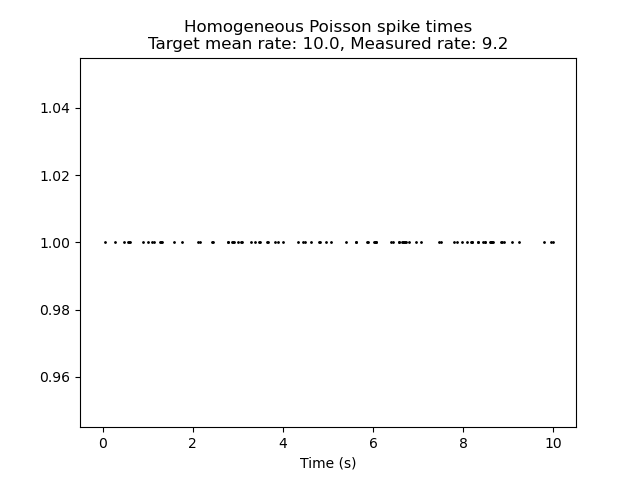

Text(0.5, 1.0, 'Homogeneous Poisson spike times\nTarget mean rate: 10.0, Measured rate: 9.2')

In [3]:
const_activity = np.random.poisson(example_rate * dt)

plt.figure()
indexes = np.where(const_activity > 0.)
measured_rate = len(indexes[0]) / len(const_activity) / dt
plt.scatter(t[indexes], np.ones_like(indexes), c='k', s=1.)
plt.xlabel('Time (s)')
plt.xlim(-0.5, 10.5)
plt.title('Homogeneous Poisson spike times\nTarget mean rate: %.1f, Measured rate: %.1f' % (mean_rate, measured_rate))

What if we have a time-varying target firing rate?

<IPython.core.display.Javascript object>


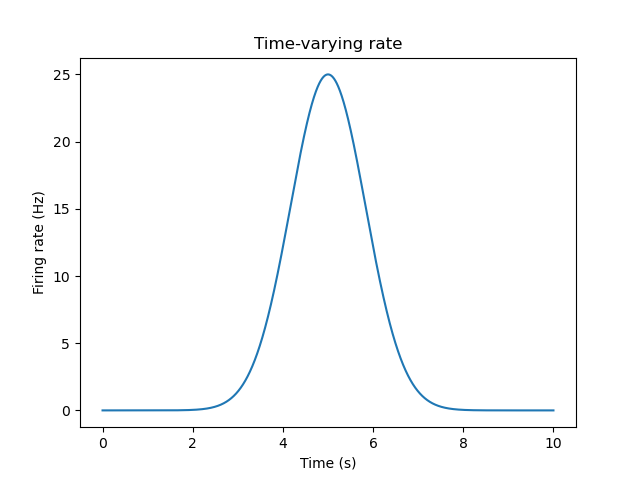

Text(0.5, 1.0, 'Time-varying rate')

In [4]:
exc_peak_rate = 25.
loc = 5.
width = 5.
sigma = width / 3. / np.sqrt(2.)
gauss_rate = exc_peak_rate * np.exp(-((t-loc)/sigma)**2.)

plt.figure()
plt.plot(t, gauss_rate)
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (s)')
plt.title('Time-varying rate')

<IPython.core.display.Javascript object>


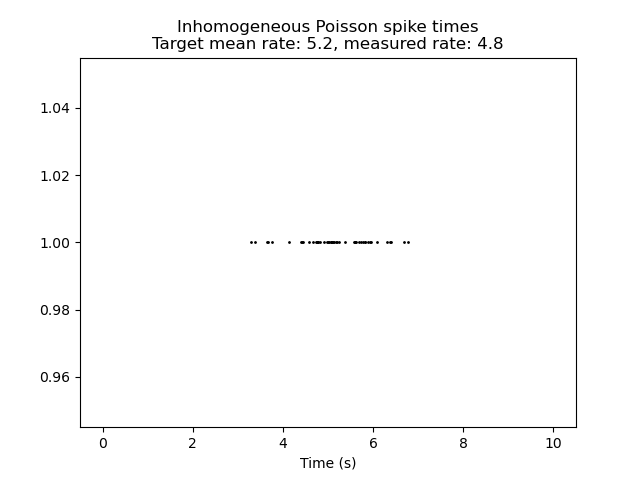

Text(0.5, 1.0, 'Inhomogeneous Poisson spike times\nTarget mean rate: 5.2, measured rate: 4.8')

In [5]:
gauss_spikes = np.random.poisson(gauss_rate * dt)

plt.figure()
indexes = np.where(gauss_spikes > 0.)
measured_rate = len(indexes[0]) / len(gauss_spikes) / dt
plt.scatter(t[indexes], np.ones_like(indexes), c='k', s=1.)
plt.xlabel('Time (s)')
plt.xlim(-0.5, 10.5)
plt.title('Inhomogeneous Poisson spike times\nTarget mean rate: %.1f, measured rate: %.1f' % (np.mean(gauss_rate), measured_rate))

We can perform a simple smoothing to convert our spikes train back to a firing rate.

<IPython.core.display.Javascript object>


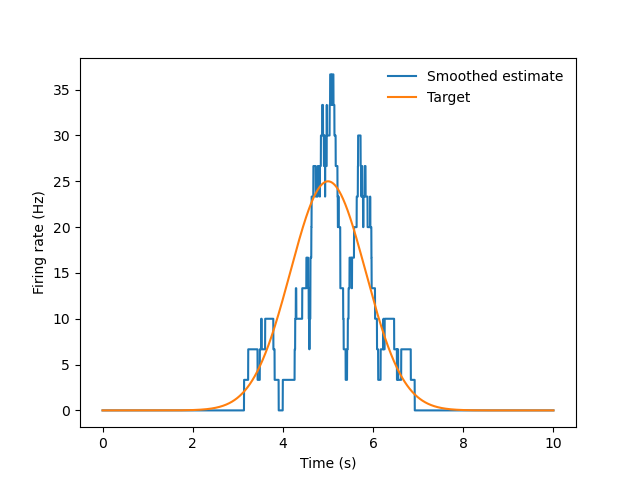

In [6]:
window = 0.3  # seconds
kernel = np.ones(int(window/dt)) / (window/dt)

from scipy.ndimage import convolve

smoothed_rate_estimate = convolve(gauss_spikes / dt, kernel, mode='wrap')

plt.figure()
plt.plot(t, smoothed_rate_estimate, label='Smoothed estimate')
plt.plot(t, gauss_rate, label='Target')
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (s)')
plt.legend(loc='best', frameon=False)

This should improve on average over many trials:

<IPython.core.display.Javascript object>


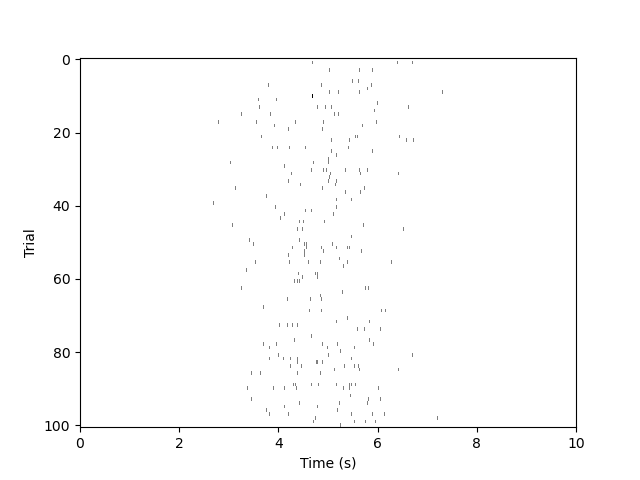

Text(0.5, 0, 'Time (s)')

In [7]:
gauss_spikes_trials = np.random.poisson(gauss_rate * dt, (100, len(t)))

plt.figure()
plt.imshow(gauss_spikes_trials, aspect='auto', cmap='binary', interpolation='none', extent=(0., 10., 100.5, -0.5))
plt.ylabel('Trial')
plt.xlabel('Time (s)')

<IPython.core.display.Javascript object>


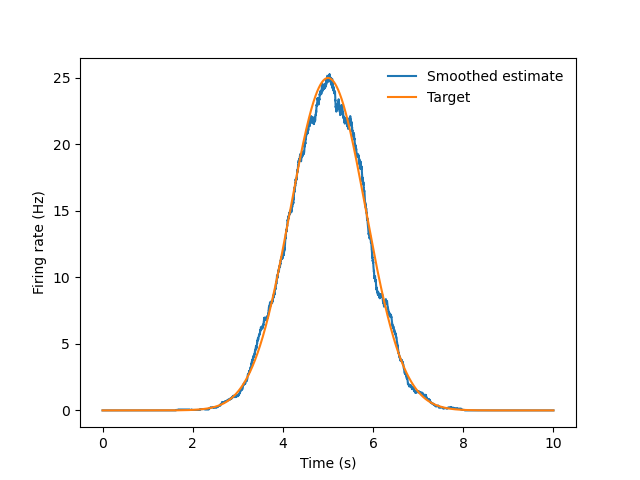

In [8]:
smoothed_rate_estimate = convolve(np.mean(gauss_spikes_trials, axis=0) / dt, kernel, mode='wrap')
plt.figure()
plt.plot(t, smoothed_rate_estimate, label='Smoothed estimate')
plt.plot(t, gauss_rate, label='Target')
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (s)')
plt.legend(loc='best', frameon=False)

Now let's build a population of neurons with time-varying firing rates, each active at a different time.

<IPython.core.display.Javascript object>


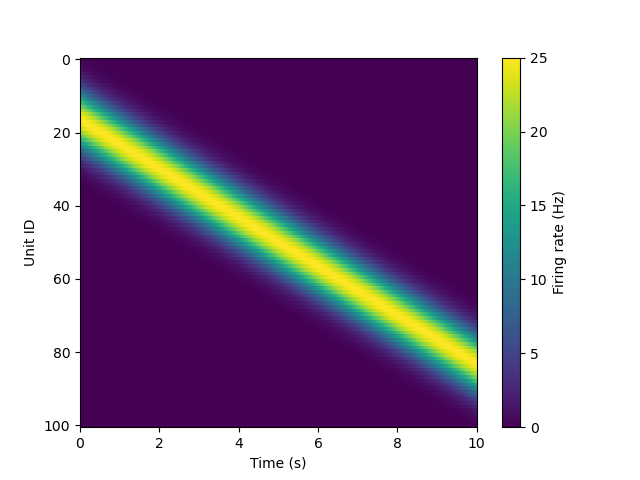

Text(0.5, 0, 'Time (s)')

In [9]:
num_units = 100
locs = np.linspace(-width/2., dur + width/2., 100)

get_gauss_rate = lambda loc: exc_peak_rate * np.exp(-((t-loc)/sigma)**2.)
uniform_rate_activity_matrix = np.empty((num_units, len(t)))
for i, loc in enumerate(locs):
    uniform_rate_activity_matrix[i] = get_gauss_rate(loc)
    
plt.figure()
plt.imshow(uniform_rate_activity_matrix, aspect='auto', interpolation='none', extent=(0., dur, num_units+0.5, -0.5))
plt.colorbar(label='Firing rate (Hz)')
plt.ylabel('Unit ID')
plt.xlabel('Time (s)')

We distributed the activity uniformly such that the summed activity of the population will be equal throughout a trial.

<IPython.core.display.Javascript object>


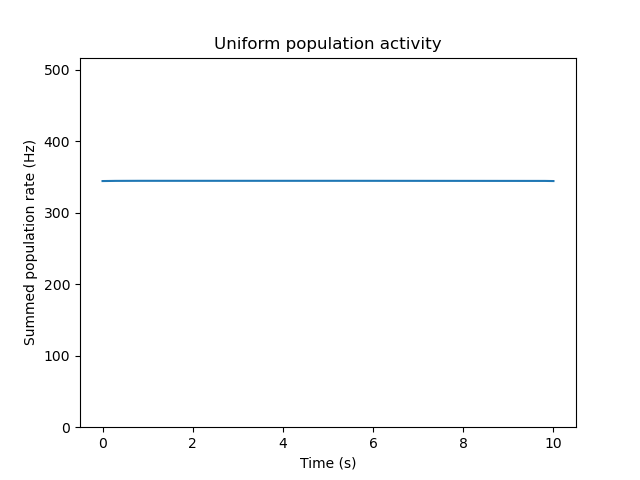

Text(0.5, 1.0, 'Uniform population activity')

In [10]:
plt.figure()
plt.plot(t, np.sum(uniform_rate_activity_matrix, axis=0))
plt.ylim(0., plt.ylim()[1] * 1.5)
plt.ylabel('Summed population rate (Hz)')
plt.xlabel('Time (s)')
plt.title('Uniform population activity')

What if the distribution of activity across the population was skewed?

<IPython.core.display.Javascript object>


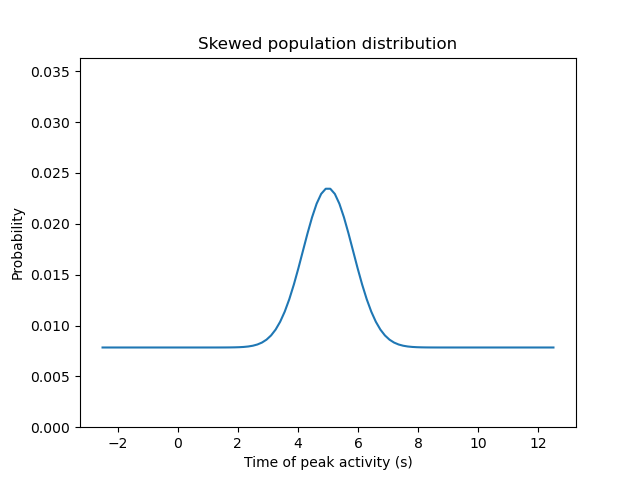

Text(0.5, 1.0, 'Skewed population distribution')

In [11]:
skewed_locs_probability = 1 + 2. * np.exp(-((locs-5.)/sigma)**2.)
skewed_locs_probability /= np.sum(skewed_locs_probability)

plt.figure()
plt.plot(locs, skewed_locs_probability)
plt.ylim(0., plt.ylim()[1]*1.5)
plt.ylabel('Probability')
plt.xlabel('Time of peak activity (s)')
plt.title('Skewed population distribution')

<IPython.core.display.Javascript object>


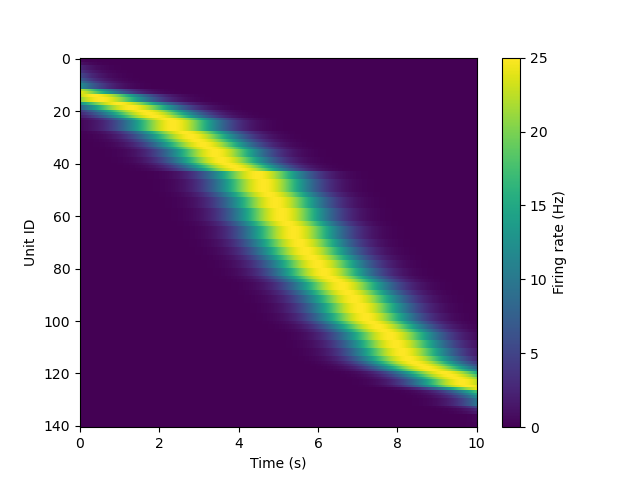

Text(0.5, 0, 'Time (s)')

In [12]:
num_skewed_units = 140
skewed_locs = np.random.choice(locs, num_skewed_units, p=skewed_locs_probability)
skewed_locs = np.sort(skewed_locs)

skewed_rate_activity_matrix = np.empty((num_skewed_units, len(t)))
for i, loc in enumerate(skewed_locs):
    skewed_rate_activity_matrix[i] = get_gauss_rate(loc)

plt.figure()
plt.imshow(skewed_rate_activity_matrix, aspect='auto', interpolation='none', extent=(0., dur, num_skewed_units+0.5, -0.5))
plt.colorbar(label='Firing rate (Hz)')
plt.ylabel('Unit ID')
plt.xlabel('Time (s)')

<IPython.core.display.Javascript object>


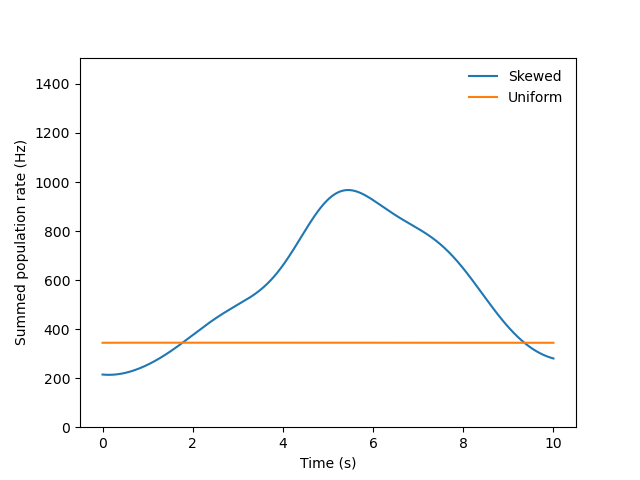

In [13]:
plt.figure()
plt.plot(t, np.sum(skewed_rate_activity_matrix, axis=0), label='Skewed')
plt.plot(t, np.sum(uniform_rate_activity_matrix, axis=0), label='Uniform')
plt.ylim(0., plt.ylim()[1] * 1.5)
plt.ylabel('Summed population rate (Hz)')
plt.xlabel('Time (s)')
plt.legend(loc='best', frameon=False)

In [14]:
def activity_to_spikes(activity, dt):
    return np.random.poisson(activity * dt)

<IPython.core.display.Javascript object>


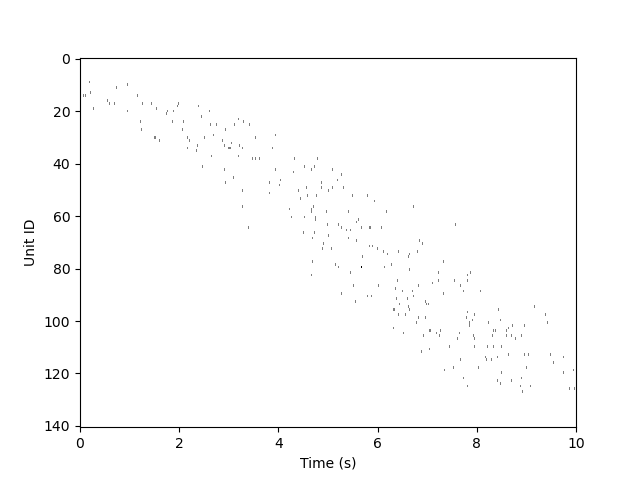

Text(0.5, 0, 'Time (s)')

In [15]:
skewed_rate_spikes_matrix = activity_to_spikes(skewed_rate_activity_matrix, dt)
plt.figure()
plt.imshow(skewed_rate_spikes_matrix, aspect='auto', cmap='binary', interpolation='none', extent=(0., dur, num_skewed_units+0.5, -0.5))
plt.ylabel('Unit ID')
plt.xlabel('Time (s)')

Next, we want to model the intracellular voltage of a single postsynaptic neuron receiving the activity from this population of neurons:<br><br>
The physical membrane of a neuron prevents charge from permeating in and out of the cell. This separation of charge creates a potential energy, or voltage difference between the inside and the outside of the cell.<br><br>
Every physical material takes time to change the amount of charge it separates when a voltage change is applied. This property is called capacitance, and it slows down how quickly the system can equilibrate to perturbation.

Charge = Capacitance * Voltage<br>
## $ Q=C*V_m $

Taking the derivative wrt to time:<br><br>
Current = Capacitance * (Rate of change in Voltage)
## $ \frac{dQ}{dt}=I_{injected}=C*\frac{dV}{dt} $

So injecting a current $ I $ into a cell will elicit a change in voltage with a timecourse that depends on the charging time of the membrane capacitor.<br><br>
But charge DOES "leak" out of the cells membrane through ion channels:
## $ I_{injected} + I_{channels}=C*\frac{dV}{dt} $

When an ion channel opens, it forms a hole, or pore in the membrane and allows certain ions to pass through.<br><br>
Every ion will move along a chemical concentration gradient, and also along an electrical gradient.<br><br>
<img src="images/ions.jpg" width="500">

Each ion channel fluxes different ions, and stops fluxing any current when those ions are at electrochemical equilibrium.<br><br>
The Nernst equation relates current through a synapse to the conductance ($ g $), the membrane potential ($ V $), and the equilibrium potential where current flux is zero ($ E $):<br><br>
Current = conductance * (Voltage - Equilibrium/Reversal Potential)<br>
## $ I_{channel}=g_{channel}*(V-E_{channel}) $


The "input resistance" of a cells membrane to current flow is inversely proportional to the conductance of its open ion channels:<br>
## $ g_{channels}=\frac{1}{R_{input}} $

Putting this all together:<br>
## $ C*\frac{dV}{dt}=g_{leak}*(V-E_{leak})+I_{injected} $
## $ C*\frac{dV}{dt}=\frac{1}{R_{input}}*(V-E_{leak})+I_{injected} $
## $ R_{input}*C*\frac{dV}{dt}=(V-E_{leak})+I_{injected}*R_{input} $

Now we can see that the input resistance ($ R_{input} $) also affects how quickly the membrane voltage changes in response to injected current.<br><br>
This is usually expressed simply as a time constant:<br>
## $ \tau_{cell}*\frac{dV}{dt}=(V-E_{leak})+I_{injected}*R_{input} $

Now we can write some functions to simulate the time evolution of the membrane voltage of a neuron receiving an input:

In [16]:
def get_dvdt(v, i, v_rest=-65., r_inp=100., cell_tau=0.02):
    """
    Differential equation describing a leaky neuron receiving an input.
    :param v: float; cell voltage (mV)
    :param i: float; summed synaptic current (nA)
    :param v_rest: float; resting voltage (mV)
    :param r_inp: float; cell membrance or input resistance (MOhm = mV/nA)
    :param cell_tau: float; cell membrane time constant (seconds)
    """
    dvdt = (-(v - v_rest) + i * r_inp) / cell_tau
    return dvdt


def sim_v_current_injection(t, i, v0, dt):
    v = np.empty_like(t)
    vi = v0
    for index, this_i in enumerate(i):
        dvdt = get_dvdt(vi, this_i)
        vi += dvdt * dt
        v[index] = vi
    return v

<IPython.core.display.Javascript object>


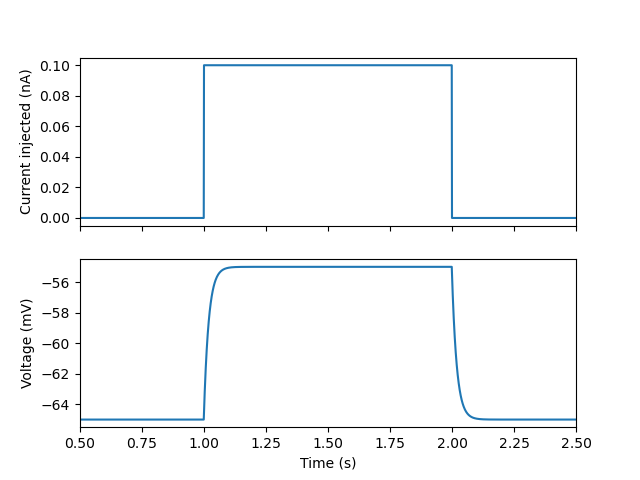

In [17]:
i = np.zeros_like(t)
i[np.where((t >= 1.) & (t < 2.))] = 0.1

v = sim_v_current_injection(t, i, -65., dt)

fig, axes = plt.subplots(2, sharex=True)
axes[0].plot(t, i)
axes[0].set_ylabel('Current injected (nA)')
axes[1].plot(t, v)
axes[1].set_ylabel('Voltage (mV)')
axes[1].set_xlim(0.5, 2.5)
axes[1].set_xlabel('Time (s)')
fig.show()

Next we want the current injected into the cell to come from synapses receiving presynaptic spikes as input.

The following specifies the amplitude and timecourse of synaptic currents:

In [18]:
def get_didt(i, syn_tau=0.01):
    """
    Differential equation describing the decay of a synaptic current over time.
    :param i: float; summed synaptic current (nA)
    :param syn_tau: float; synaptic ion channel deactivation time constant (seconds)
    """
    didt = -i / syn_tau
    return didt


def sim_v_spiking_input(t, activity_matrix, weights, v0, dt):
    v = np.empty_like(t)
    summed_i_history = np.empty_like(t)
    vi = v0
    i_array = np.zeros(activity_matrix.shape[0])
    
    for index in range(len(t)):
        pre_array = activity_matrix[:,index]
        
        didt = get_didt(i_array)
        i_array += didt * dt + pre_array * weights
        summed_i = np.sum(i_array)
        summed_i_history[index] = summed_i
        
        dvdt = get_dvdt(vi, summed_i)
        vi += dvdt * dt
        v[index] = vi
    return v, summed_i_history

First lets provide just one synaptic input with one of the spike trains we generated above:

<IPython.core.display.Javascript object>


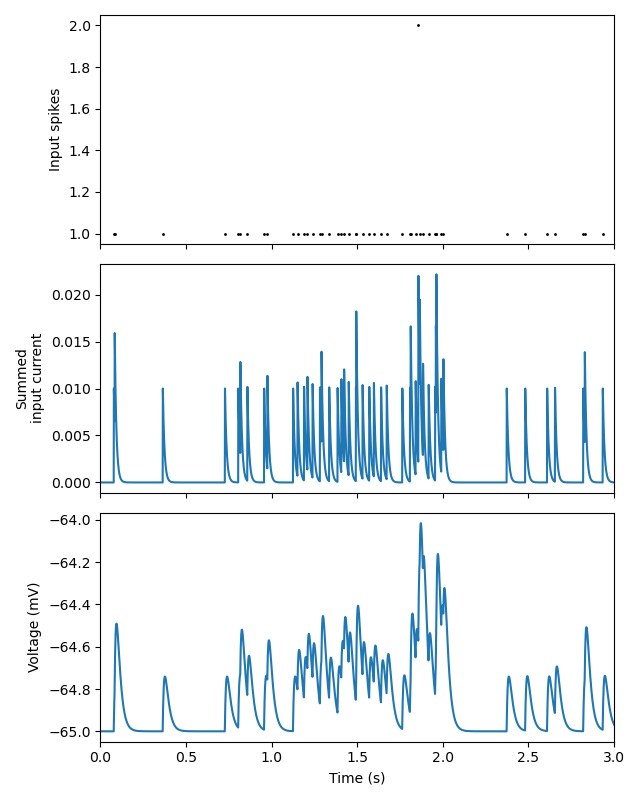

In [19]:
test_spikes = skewed_rate_spikes_matrix[None, 20, :]
test_weights = np.array([0.01])

v, summed_i = sim_v_spiking_input(t, test_spikes, test_weights, -65., dt)

fig, axes = plt.subplots(3, sharex=True, figsize=(6.4, 8.))
indexes = np.where(test_spikes[0] > 0.)
axes[0].scatter(t[indexes], test_spikes[0][indexes], c='k', s=1.)
axes[0].set_ylabel('Input spikes')
axes[1].plot(t, summed_i)
axes[1].set_ylabel('Summed\ninput current')
axes[2].plot(t, v)
axes[2].set_ylabel('Voltage (mV)')
axes[2].set_xlabel('Time (s)')
axes[2].set_xlim(0., 3.)
fig.tight_layout()
fig.show()

Now we'll stimulate all the inputs from the skewed population spiking activity above:

<IPython.core.display.Javascript object>


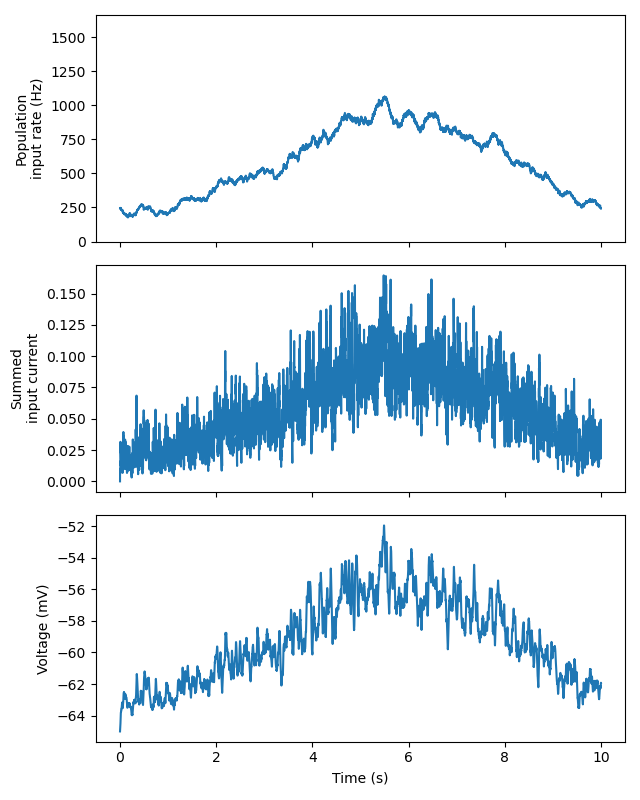

In [20]:
uniform_weights = np.ones(skewed_rate_spikes_matrix.shape[0]) * 0.01

skewed_rate_v, skewed_rate_summed_i = sim_v_spiking_input(t, skewed_rate_spikes_matrix, uniform_weights, -65., dt)

skewed_rate_smoothed_rate_estimate = convolve(np.sum(skewed_rate_spikes_matrix, axis=0) / dt, kernel, mode='wrap')

fig, axes = plt.subplots(3, sharex=True, figsize=(6.4, 8.))
axes[0].plot(t, skewed_rate_smoothed_rate_estimate)
axes[0].set_ylabel('Population\ninput rate (Hz)')
axes[0].set_ylim(0., axes[0].get_ylim()[1]*1.5)
axes[1].plot(t, skewed_rate_summed_i)
axes[1].set_ylabel('Summed\ninput current')
axes[2].plot(t, skewed_rate_v)
axes[2].set_ylabel('Voltage (mV)')
axes[2].set_xlabel('Time (s)')
# axes[2].set_xlim(0., 3.)
fig.tight_layout()
fig.show()

Here the bias in the input was produced by a skewed population firing rate.<br>
Let's instead start with a uniform population firing rate and introduce the bias with skewed synaptic weights.

<IPython.core.display.Javascript object>


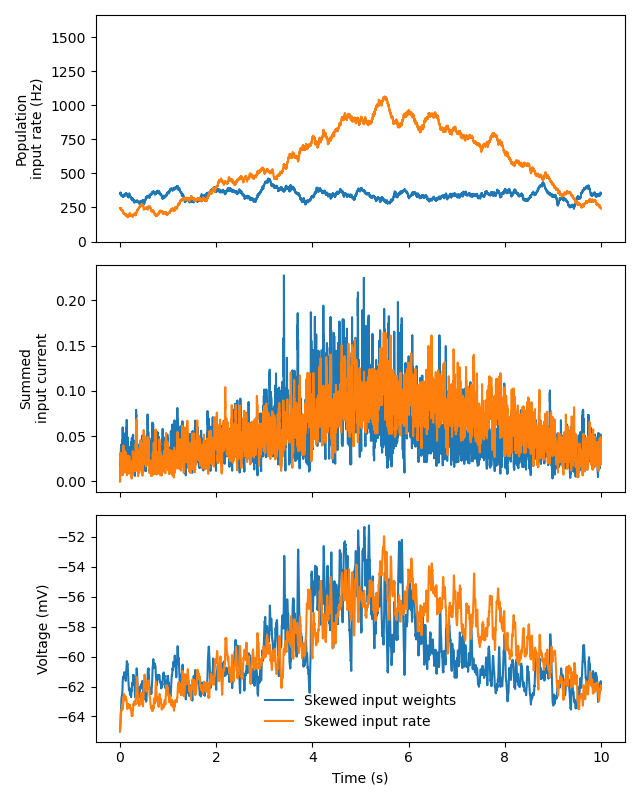

In [21]:
uniform_rate_spikes_matrix = activity_to_spikes(uniform_rate_activity_matrix, dt)

skewed_weights = 0.01 * (1 + 2.5 * np.exp(-((locs-5.)/sigma)**2.))

skewed_weight_v, skewed_weight_summed_i = sim_v_spiking_input(t, uniform_rate_spikes_matrix, skewed_weights, -65., dt)

skewed_weight_smoothed_rate_estimate = convolve(np.sum(uniform_rate_spikes_matrix, axis=0) / dt, kernel, mode='wrap')

fig, axes = plt.subplots(3, sharex=True, figsize=(6.4, 8.))
axes[0].plot(t, skewed_weight_smoothed_rate_estimate)
axes[0].plot(t, skewed_rate_smoothed_rate_estimate)
axes[0].set_ylabel('Population\ninput rate (Hz)')
axes[0].set_ylim(0., axes[0].get_ylim()[1]*1.5)
axes[1].plot(t, skewed_weight_summed_i)
axes[1].plot(t, skewed_rate_summed_i)
axes[1].set_ylabel('Summed\ninput current')
axes[2].plot(t, skewed_weight_v, label='Skewed input weights')
axes[2].plot(t, skewed_rate_v, label='Skewed input rate')
axes[2].legend(loc='best', frameon=False)
axes[2].set_ylabel('Voltage (mV)')
axes[2].set_xlabel('Time (s)')
fig.tight_layout()
fig.show()

What can distinguish these two methods to drive a neuron's selectivity?

<img src="images/rotter_eq.jpg" width="500">
Kuhn, A., Aertsen, A., Rotter, S., 2004. Neuronal Integration of Synaptic Input in the Fluctuation-Driven Regime. J Neurosci 24, 2345–2356. https://doi.org/10.1523/jneurosci.3349-03.2004

<img src="images/magee_vm_var.jpg" width="1500">
Bittner, K.C., Grienberger, C., Vaidya, S.P., Milstein, A.D., Macklin, J.J., Suh, J., Tonegawa, S., Magee, J.C., 2015. Conjunctive input processing drives feature selectivity in hippocampal CA1 neurons. Nat Neurosci 18, 1133–42. https://doi.org/10.1038/nn.4062

In [22]:
def var_in_window(signal, window, dt, wrap=True):
    """
    Compute the variance of a signal in a sliding window.
    """
    window_len = int(window/dt)
    half_len = window_len // 2
    var_array = np.empty_like(signal)
    for i in range(len(signal)):
        if wrap:
            val = np.var(np.roll(signal, half_len - i)[:window_len])
        else:
            val = np.var(signal[max(0, i-half_len):i+half_len])
        var_array[i] = val
    return var_array

<IPython.core.display.Javascript object>


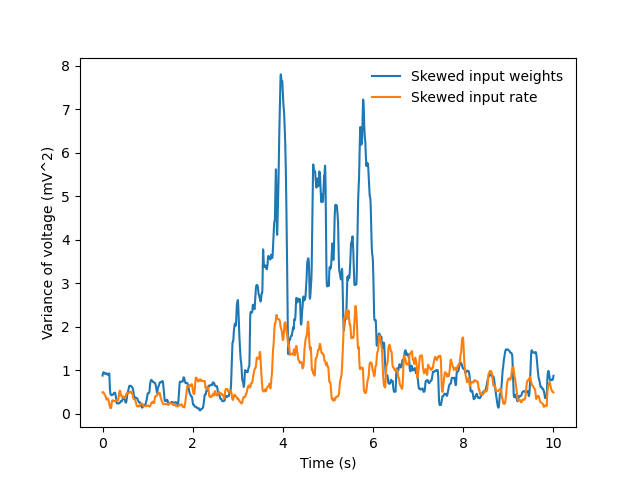

In [23]:
skewed_weight_var = var_in_window(skewed_weight_v, window, dt)
skewed_rate_var = var_in_window(skewed_rate_v, window, dt)

plt.figure()
plt.plot(t, skewed_weight_var, label='Skewed input weights')
plt.plot(t, skewed_rate_var, label='Skewed input rate')
plt.ylabel('Variance of voltage (mV^2)')
plt.xlabel('Time (s)')
plt.legend(loc='best', frameon=False)

## What happens if we add inhibitory inputs?

<IPython.core.display.Javascript object>


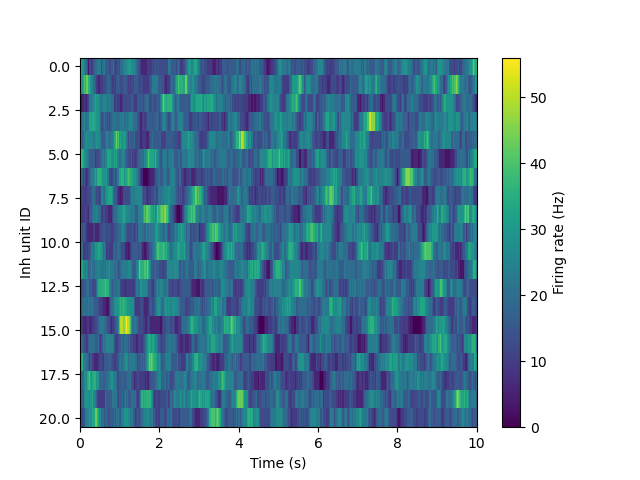

In [24]:
num_inh_inputs = 20
peak_inh_rate = 20.

uniform_inh_rate_matrix = np.ones((num_inh_inputs, len(t))) * peak_inh_rate

uniform_inh_spikes_matrix = activity_to_spikes(uniform_inh_rate_matrix, dt)

uniform_inh_smoothed_rate_estimate_matrix = np.empty_like(uniform_inh_spikes_matrix)
for i, spikes in enumerate(uniform_inh_spikes_matrix):
    uniform_inh_smoothed_rate_estimate_matrix[i] = convolve(spikes / dt, kernel, mode='wrap')

plt.figure()
plt.imshow(uniform_inh_smoothed_rate_estimate_matrix, aspect='auto', interpolation='none', extent=(0., dur, num_inh_inputs+0.5, -0.5))
plt.colorbar(label='Firing rate (Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Inh unit ID')
plt.show()

We'll need to redefine our simulation function to accept multiple populations.<br>Inputs from the inhibitory population will have negative weights.

In [25]:
weights_dict = {}
weights_dict['exc'] = uniform_weights
weights_dict['inh'] = np.ones(num_inh_inputs) * -0.01

spikes_matrix_dict = {}
spikes_matrix_dict['exc'] = skewed_rate_spikes_matrix
spikes_matrix_dict['inh'] = uniform_inh_spikes_matrix


def sim_v_spiking_input(t, activity_matrix_dict, weights_dict, v0, dt):
    v = np.empty_like(t)
    summed_i_history = np.empty_like(t)
    vi = v0
    i_dict = {}
    for pop in activity_matrix_dict:
        i_dict[pop] = np.zeros(activity_matrix_dict[pop].shape[0])
    for index in range(len(t)):
        summed_i = 0.
        for pop in activity_matrix_dict:
            pre_array = activity_matrix_dict[pop][:,index]
            weight_array = weights_dict[pop]
            didt = get_didt(i_dict[pop])
            i_dict[pop] += didt * dt + pre_array * weight_array
            summed_i += np.sum(i_dict[pop])
        summed_i_history[index] = summed_i
        dvdt = get_dvdt(vi, summed_i)
        vi += dvdt * dt
        v[index] = vi
    return v, summed_i_history


v, summed_i = sim_v_spiking_input(t, spikes_matrix_dict, weights_dict, -65., dt)

var = var_in_window(v, window, dt)

<IPython.core.display.Javascript object>


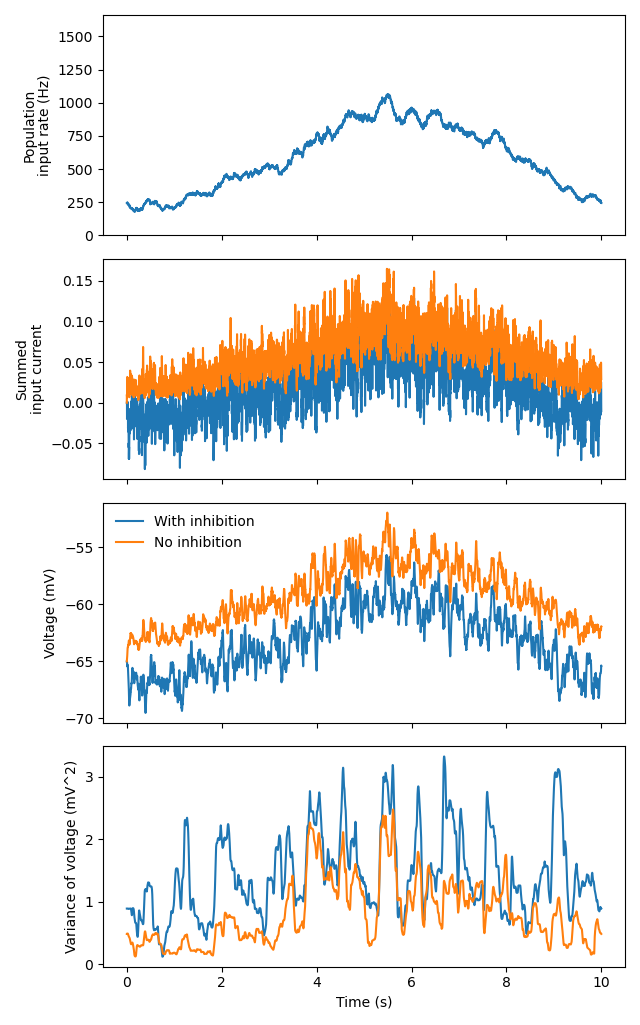

In [26]:
fig, axes = plt.subplots(4, sharex=True, figsize=(6.4, 10.25))
axes[0].plot(t, skewed_rate_smoothed_rate_estimate)
axes[0].set_ylabel('Population\ninput rate (Hz)')
axes[0].set_ylim(0., axes[0].get_ylim()[1]*1.5)
axes[1].plot(t, summed_i)
axes[1].plot(t, skewed_rate_summed_i)
axes[1].set_ylabel('Summed\ninput current')
axes[2].plot(t, v, label='With inhibition')
axes[2].plot(t, skewed_rate_v, label='No inhibition')
axes[2].legend(loc='best', frameon=False)
axes[2].set_ylabel('Voltage (mV)')
axes[3].set_xlabel('Time (s)')
axes[3].plot(t, var)
axes[3].plot(t, skewed_rate_var)
axes[3].set_ylabel('Variance of voltage (mV^2)')
fig.tight_layout()
fig.show()

With "current-based" synapses, adding inhibition decreases the mean voltage, but increases the variance of the membrane potential!

What about with conductance-based synapses?<br><br>
Here's the Nernst equation again:<br>
## $ I_{channel}=g_{channel}*(V-E_{channel}) $

For excitatory AMPA-type glutamate receptors, $ E_{AMPA}=0 $ mV<br><br>
For inhibitory GABA(A)-type receptors, $ E_{GABA}=-70 $ mV<br>
<img src="images/ampa_iv.jpg" width="500">

In [27]:
def get_dgdt(g, syn_tau=0.01):
    """
    Differential equation describing the decay of a synaptic conductance over time.
    :param i: float; summed synaptic current (nA)
    :param syn_tau: float; synaptic ion channel deactivation time constant (seconds)
    """
    dgdt = -g / syn_tau
    return dgdt


v_eq_dict = {}
v_eq_dict['exc'] = 0.
v_eq_dict['inh'] = -70.


def sim_v_spiking_input(t, activity_matrix_dict, weights_dict, v_eq_dict, v0, dt):
    v = np.empty_like(t)
    summed_i_history = np.empty_like(t)
    vi = v0
    g_dict = {}
    for pop in activity_matrix_dict:
        g_dict[pop] = np.zeros(activity_matrix_dict[pop].shape[0])
    for index in range(len(t)):
        summed_i = 0.
        for pop in activity_matrix_dict:
            pre_array = activity_matrix_dict[pop][:,index]
            weight_array = weights_dict[pop]
            dgdt = get_dgdt(g_dict[pop])
            g_dict[pop] += dgdt * dt + pre_array * weight_array
            # now conductance weights can all be positive, and the sign of the current is determined by v and v_eq
            i_array = g_dict[pop] * (v_eq_dict[pop] - vi)
            summed_i += np.sum(i_array)
        summed_i_history[index] = summed_i
        dvdt = get_dvdt(vi, summed_i)
        vi += dvdt * dt
        v[index] = vi
    return v, summed_i_history

In [28]:
weights_dict = {}
uniform_g_exc_weights = np.ones(num_skewed_units) * 0.0003
uniform_g_inh_weights = np.ones(num_inh_inputs) * 0.002
weights_dict['exc'] = uniform_g_exc_weights
weights_dict['inh'] = uniform_g_inh_weights

spikes_matrix_dict = {}
spikes_matrix_dict['exc'] = skewed_rate_spikes_matrix
spikes_matrix_dict['inh'] = uniform_inh_spikes_matrix

v_dict, summed_i_dict, var_dict = {}, {}, {}

condition = 'With Inh (g)'

v_dict[condition], summed_i_dict[condition] = sim_v_spiking_input(t, spikes_matrix_dict, weights_dict, v_eq_dict, -65., dt)

var_dict[condition] = var_in_window(v_dict[condition], window, dt)

condition = 'No Inh (g)'

weights_dict = {}
weights_dict['exc'] = uniform_g_exc_weights

spikes_matrix_dict = {}
spikes_matrix_dict['exc'] = skewed_rate_spikes_matrix

v_dict[condition], summed_i_dict[condition] = sim_v_spiking_input(t, spikes_matrix_dict, weights_dict, v_eq_dict, -65., dt)

var_dict[condition] = var_in_window(v_dict[condition], window, dt)

/Users/aaronmil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


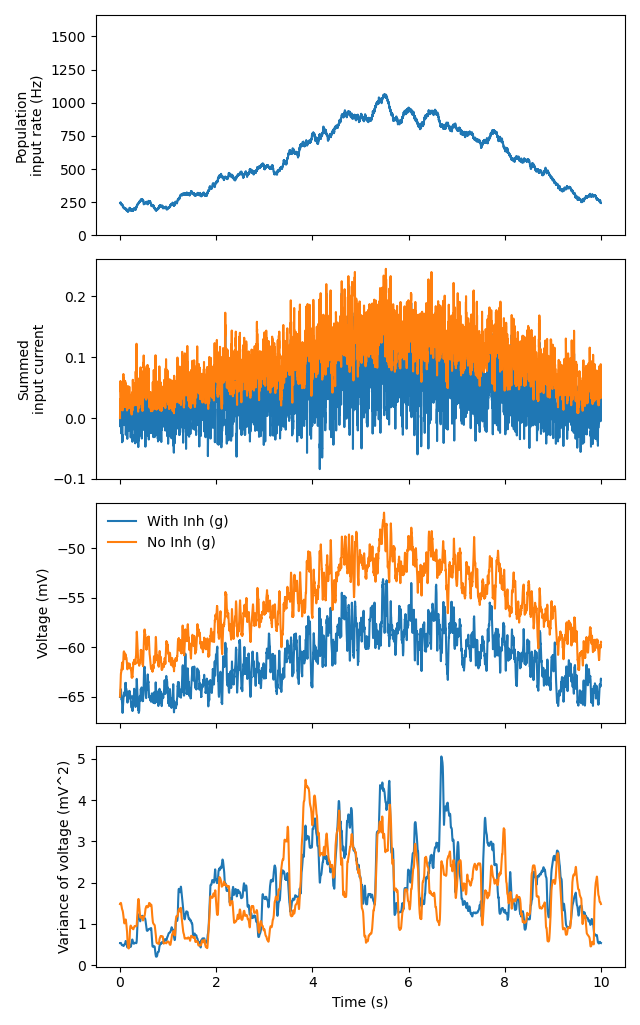

In [29]:
fig, axes = plt.subplots(4, sharex=True, figsize=(6.4, 10.25))
axes[0].plot(t, skewed_rate_smoothed_rate_estimate)
axes[0].set_ylabel('Population\ninput rate (Hz)')
axes[0].set_ylim(0., axes[0].get_ylim()[1]*1.5)
for condition in v_dict:
    axes[1].plot(t, summed_i_dict[condition])
    axes[1].set_ylabel('Summed\ninput current')
    axes[2].plot(t, v_dict[condition], label=condition)
    axes[2].legend(loc='best', frameon=False)
    axes[2].set_ylabel('Voltage (mV)')
    axes[3].set_xlabel('Time (s)')
    axes[3].plot(t, var_dict[condition])
    axes[3].set_ylabel('Variance of voltage (mV^2)')
fig.tight_layout()
fig.show()

## The behavior is quite different with conductance-based synapses:

<img src="images/rotter_vm_var.jpg" width="750">
Kuhn, A., Aertsen, A., Rotter, S., 2004. Neuronal Integration of Synaptic Input in the Fluctuation-Driven Regime. J Neurosci 24, 2345–2356. https://doi.org/10.1523/jneurosci.3349-03.2004

## But there is another source of excitatory current: voltage-dependent NMDA-type glutamate receptors!

<img src="images/nmda_iv.jpg" width="500">

<IPython.core.display.Javascript object>


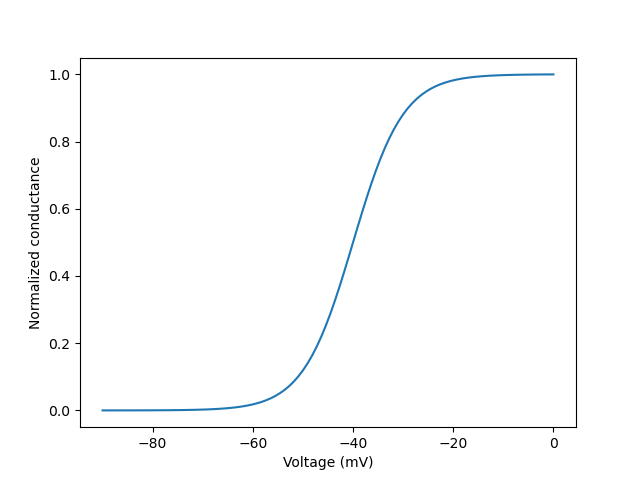

Text(0.5, 0, 'Voltage (mV)')

In [30]:
v_range = np.linspace(-90., 0., 100)
sig_nmda = lambda v: 1./(1.+np.exp(-0.2*(v+40)))
plt.figure()
plt.plot(v_range, sig_nmda(v_range))
plt.ylabel('Normalized conductance')
plt.xlabel('Voltage (mV)')

In [31]:
def get_dgdt(g, syn_tau=0.01):
    """
    Differential equation describing the decay of a synaptic conductance over time.
    :param i: float; summed synaptic current (nA)
    :param syn_tau: float; synaptic ion channel deactivation time constant (seconds)
    """
    dgdt = -g / syn_tau
    return dgdt


v_eq_dict = {}
v_eq_dict['AMPA'] = 0.
v_eq_dict['NMDA'] = 0.
v_eq_dict['GABA'] = -70.

syn_tau_dict = {}
syn_tau_dict['AMPA'] = 0.01
syn_tau_dict['NMDA'] = 0.03
syn_tau_dict['GABA'] = 0.01


def sim_v_spiking_input(t, activity_matrix_dict, weights_dict, v_eq_dict, syn_tau_dict, v0, dt):
    v = np.empty_like(t)
    summed_i_history = np.empty_like(t)
    vi = v0
    g_dict = {}
    for pop in activity_matrix_dict:
        g_dict[pop] = np.zeros(activity_matrix_dict[pop].shape[0])
    for index in range(len(t)):
        summed_i = 0.
        for pop in activity_matrix_dict:
            pre_array = activity_matrix_dict[pop][:,index]
            weight_array = weights_dict[pop]
            dgdt = get_dgdt(g_dict[pop], syn_tau=syn_tau_dict[pop])
            g_dict[pop] += dgdt * dt + pre_array * weight_array
            # now conductance weights can all be positive, and the sign of the current is determined by v and v_eq
            if pop == 'NMDA':
                i_array = g_dict[pop] * (v_eq_dict[pop] - vi) * sig_nmda(vi)
            else:
                i_array = g_dict[pop] * (v_eq_dict[pop] - vi)
            summed_i += np.sum(i_array)
        summed_i_history[index] = summed_i
        dvdt = get_dvdt(vi, summed_i)
        vi += dvdt * dt
        v[index] = vi
    return v, summed_i_history

In [32]:
weights_dict = {}
uniform_g_AMPA_weights = np.ones(num_skewed_units) * 0.0003
uniform_g_NMDA_weights = np.ones(num_skewed_units) * 0.000075
uniform_g_GABA_weights = np.ones(num_inh_inputs) * 0.002
weights_dict['AMPA'] = uniform_g_AMPA_weights
weights_dict['NMDA'] = uniform_g_NMDA_weights
weights_dict['GABA'] = uniform_g_GABA_weights


spikes_matrix_dict = {}
spikes_matrix_dict['AMPA'] = skewed_rate_spikes_matrix
spikes_matrix_dict['NMDA'] = skewed_rate_spikes_matrix
spikes_matrix_dict['GABA'] = uniform_inh_spikes_matrix

v_dict, summed_i_dict, var_dict = {}, {}, {}

condition = '+NMDARs +Inh'

v_dict[condition], summed_i_dict[condition] = sim_v_spiking_input(t, spikes_matrix_dict, weights_dict, v_eq_dict, syn_tau_dict, -65., dt)

var_dict[condition] = var_in_window(v_dict[condition], window, dt)

condition = '+NMDARs -Inh'

weights_dict = {}
weights_dict['AMPA'] = uniform_g_AMPA_weights
weights_dict['NMDA'] = uniform_g_NMDA_weights

spikes_matrix_dict = {}
spikes_matrix_dict['AMPA'] = skewed_rate_spikes_matrix
spikes_matrix_dict['NMDA'] = skewed_rate_spikes_matrix

v_dict[condition], summed_i_dict[condition] = sim_v_spiking_input(t, spikes_matrix_dict, weights_dict, v_eq_dict, syn_tau_dict, -65., dt)

var_dict[condition] = var_in_window(v_dict[condition], window, dt)

<IPython.core.display.Javascript object>


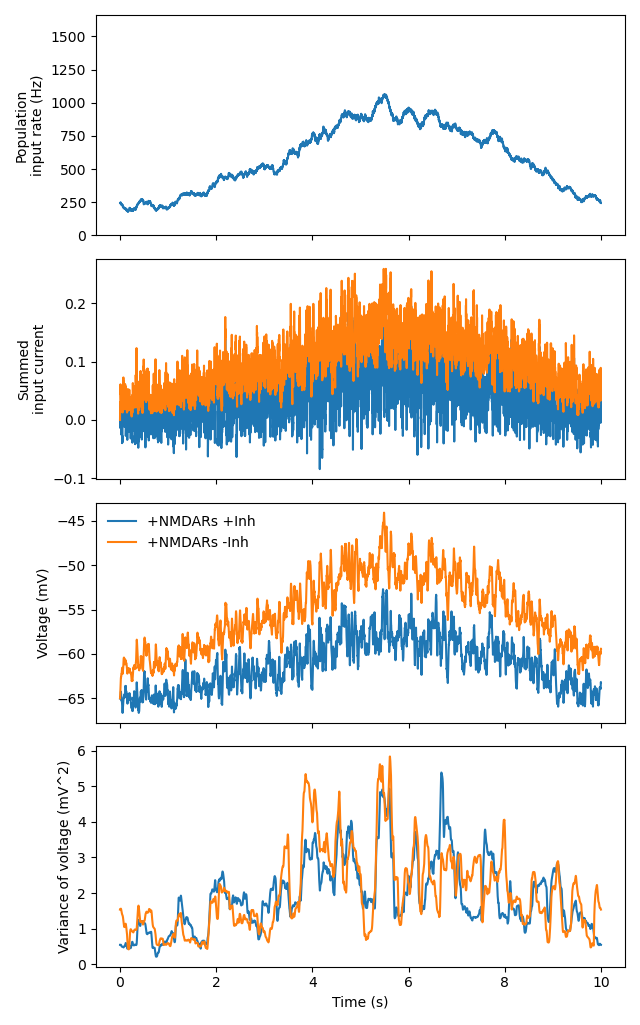

In [33]:
fig, axes = plt.subplots(4, sharex=True, figsize=(6.4, 10.25))
axes[0].plot(t, skewed_rate_smoothed_rate_estimate)
axes[0].set_ylabel('Population\ninput rate (Hz)')
axes[0].set_ylim(0., axes[0].get_ylim()[1]*1.5)
for condition in v_dict:
    axes[1].plot(t, summed_i_dict[condition])
    axes[1].set_ylabel('Summed\ninput current')
    axes[2].plot(t, v_dict[condition], label=condition)
    axes[2].legend(loc='best', frameon=False)
    axes[2].set_ylabel('Voltage (mV)')
    axes[3].set_xlabel('Time (s)')
    axes[3].plot(t, var_dict[condition])
    axes[3].set_ylabel('Variance of voltage (mV^2)')
fig.tight_layout()
fig.show()

## All of the above used skewed input rate as the selectivity mechanism. Does this hold for skewed input weights?

In [34]:
weights_dict = {}
skewed_g_AMPA_weights = (1 + 2.5 * np.exp(-((locs-5.)/sigma)**2.)) * 0.0003
uniform_g_NMDA_weights = np.ones(num_units) * 0.000075
uniform_g_GABA_weights = np.ones(num_inh_inputs) * 0.002
weights_dict['AMPA'] = skewed_g_AMPA_weights
weights_dict['NMDA'] = uniform_g_NMDA_weights
weights_dict['GABA'] = uniform_g_GABA_weights


spikes_matrix_dict = {}
spikes_matrix_dict['AMPA'] = uniform_rate_spikes_matrix
spikes_matrix_dict['NMDA'] = uniform_rate_spikes_matrix
spikes_matrix_dict['GABA'] = uniform_inh_spikes_matrix

v_dict, summed_i_dict, var_dict = {}, {}, {}

condition = '+NMDARs +Inh '

v_dict[condition], summed_i_dict[condition] = sim_v_spiking_input(t, spikes_matrix_dict, weights_dict, v_eq_dict, syn_tau_dict, -65., dt)

var_dict[condition] = var_in_window(v_dict[condition], window, dt)

condition = '+NMDARs -Inh'

weights_dict = {}
weights_dict['AMPA'] = skewed_g_AMPA_weights
weights_dict['NMDA'] = uniform_g_NMDA_weights

spikes_matrix_dict = {}
spikes_matrix_dict['AMPA'] = uniform_rate_spikes_matrix
spikes_matrix_dict['NMDA'] = uniform_rate_spikes_matrix

v_dict[condition], summed_i_dict[condition] = sim_v_spiking_input(t, spikes_matrix_dict, weights_dict, v_eq_dict, syn_tau_dict, -65., dt)

var_dict[condition] = var_in_window(v_dict[condition], window, dt)

<IPython.core.display.Javascript object>


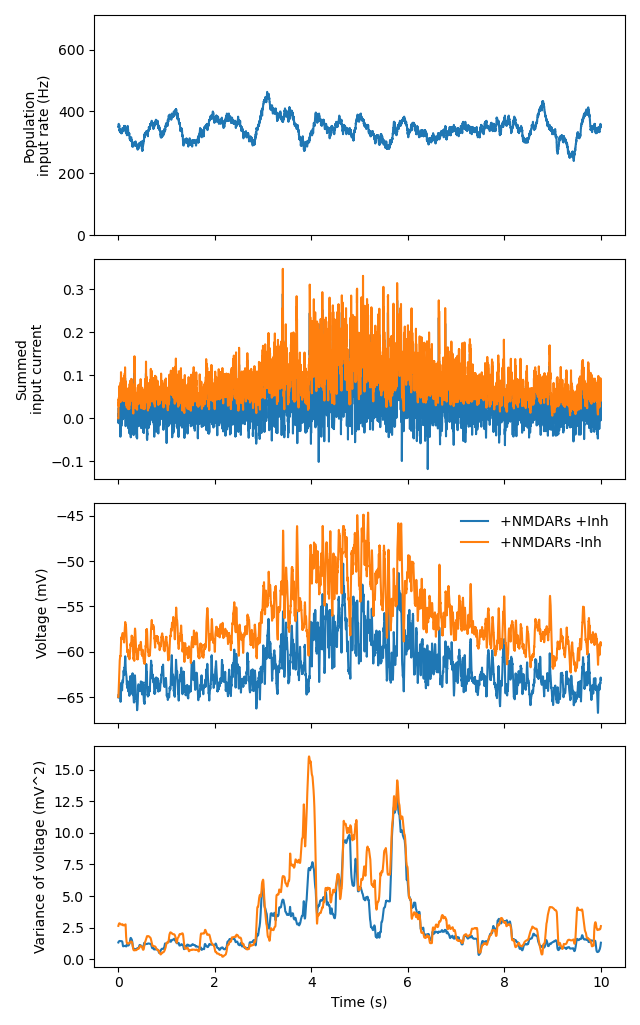

In [35]:
fig, axes = plt.subplots(4, sharex=True, figsize=(6.4, 10.25))
axes[0].plot(t, skewed_weight_smoothed_rate_estimate)
axes[0].set_ylabel('Population\ninput rate (Hz)')
axes[0].set_ylim(0., axes[0].get_ylim()[1]*1.5)
for condition in v_dict:
    axes[1].plot(t, summed_i_dict[condition])
    axes[1].set_ylabel('Summed\ninput current')
    axes[2].plot(t, v_dict[condition], label=condition)
    axes[2].legend(loc='best', frameon=False)
    axes[2].set_ylabel('Voltage (mV)')
    axes[3].set_xlabel('Time (s)')
    axes[3].plot(t, var_dict[condition])
    axes[3].set_ylabel('Variance of voltage (mV^2)')
fig.tight_layout()
fig.show()

## How does this compare to <i>in vivo</i> data?

<img src="images/grienberger_vm_var.jpg" width="1000">
Grienberger, C., Milstein, A.D., Bittner, K.C., Romani, S., Magee, J.C., 2017. Inhibitory suppression of heterogeneously tuned excitation enhances spatial coding in CA1 place cells. Nat Neurosci 20, 417–426. https://doi.org/10.1038/nn.4486

## The above tested conditions with uniform inhibitory input rates. What would we expect to happen if inhibitory input was biased?

<img src="images/Milstein_red_inh.jpg" width="1000">
Grienberger, C., Milstein, A.D., Bittner, K.C., Romani, S., Magee, J.C., 2017. Inhibitory suppression of heterogeneously tuned excitation enhances spatial coding in CA1 place cells. Nat Neurosci 20, 417–426. https://doi.org/10.1038/nn.4486

<img src="images/buzsaki_inh_pred.jpg" width="1000">
Valero, M., Zutshi, I., Yoon, E., Buzsáki, G., 2022. Probing subthreshold dynamics of hippocampal neurons by pulsed optogenetics. Science 375, 570–574. https://doi.org/10.1126/science.abm1891